# Ascaso-Extended Models Calibration


---
**License**

 Ascaso_Extended_Calibration

 Tue Aug 24 10:30:00 2021\
 Copyright  2021\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2021 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching")


#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd

import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")


# import clevar
# from clevar import ClCatalog, MemCatalog
# from clevar.match import MembershipMatch, get_matched_pairs
# from clevar.match import output_matched_catalog
# from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf


#Calibration functions
from bdata import DataB
from model_fitting import ModelFitting

## Data

### Halos m200c

In [2]:
# DC2_halos_m200c = fits.open(
#     "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

# dt_halos = Table(DC2_halos_m200c[1].data)
# dt_halos = dt_halos[dt_halos["redshift_true"] < 1.2]

# lnM = np.log(dt_halos["m200c"])  # ln(mass)
# z = dt_halos["redshift_true"]  # redshift
# lnR = np.log(dt_halos["richness"])  # ln(richness)


### Clevar

In [3]:
# CLEVAR

# min_richness = 5
# min_halo_mass = 1e13 #Msun

# #Halos/Clusters
# #SkySim + RedMaPPer: 'skysim5000_v1.1.1_redmapper_v0.8.5'
# RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

# #SkySim: 'skysim5000_v1.1.1_image'
# halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

# #Members
# RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# #Match catalogs
# mt = MembershipMatch()

# mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/SS_RM_match_cross_membership')

# info = s_cf.plot(RM_cat, halo_cat, 'cross', col='mass', xscale='log', yscale='log',
#                  col_color='z', add_err=False)

In [4]:
# Halos/Clusters
# #CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
# RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

# #CosmoDC2: 'cosmoDC2_v1.1.4_image'
# halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

# #Members
# RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# #Match catalogs
# mt = MembershipMatch()

# mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/cosmoDC2_RM_match_cross_membership')


In [5]:
# RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

# clusters_dt = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['z']], names=('m200c', 'richness', 'redshift_true'))
# dt_halos = clusters_dt[np.logical_and(clusters_dt['redshift_true'] > 0.14, clusters_dt['redshift_true']< 0.33)]
# dt_halos = dt_halos[dt_halos['richness'] > 20]
# dt_halos = clusters_dt

In [6]:
# cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')


### NumCosmo's Matching By Proximity

In [7]:
# mdata = Table.read('CatalogsMatching/match_proximity.fits')

# mass_data= [m[0] for m in data['mass']]
# rich_data = [r for r in data['richness']]
# z_data = [z for z in data['z']]

# test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

# mdata

In [8]:
# lnM_binned = bd.get_lnM_binned()
# lnR_binned = bd.get_lnR_binned()
# z_binned = bd.get_z_binned()
# bins_std = bd.get_bins_std()
# bins_mean = bd.get_bins_mean()


### Matching by ID 

In [18]:
test_matchdata = Table.read('CatalogsMatching/match_ID.fits')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift"]
mass_data = test_matchdata["halo_mass"]
r_err_data = test_matchdata["richness_err"]

test_dt = Table([mass_data, rich_data, z_data, r_err_data], names=('mass', 'richness', 'redshift', 'richness_err'))

test_dt.sort('richness')


# t2 = test_dt[:3000]

# print(t2['mass'].max())

# plt.scatter(t2['mass'], t2['richness'])

# print(np.log(5.007845))



## Models fit

### Fit 

In [10]:
bd = DataB(test_dt, 0.05, 0.05)
fm = ModelFitting(test_dt)

halos_mean = bd.get_bins_mean()
halos_std = bd.get_bins_std()


### Linear

Here we do the fitting of linear model parameters using training data in **data_train**. The model is:

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$

$\textbf{p}_{1}$ is the vector with the linear model parameters.


In [11]:
ascaso, fit_ascaso, dmr_asc = fm.run_fit('ascaso')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

In [12]:
lnR_mean_ascaso = fm.get_mean_model(ascaso,  np.log(test_dt["mass"]),  test_dt["redshift"])
lnR_std_ascaso = fm.get_std_model(ascaso,  np.log(test_dt["mass"]),  test_dt["redshift"])

### Quadratic (ln(1+z)) 
Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $\ln (1 + z)$ is considered:

\begin{equation}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

$\textbf{p}_{2}$ is the vector with the quadratic model parameters.


In [13]:
ext_ln1pz, fit_ext, dmr_ext = fm.run_fit('ext_ln1pz')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

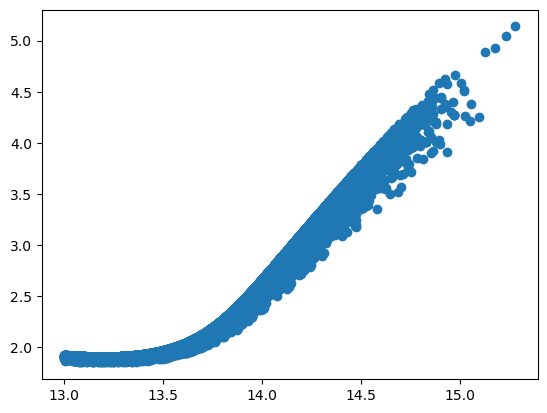

In [45]:
lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  np.log(test_dt["mass"]),  test_dt["redshift"])
lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz,  np.log(test_dt["mass"]),  test_dt["redshift"])

# print(rich_data)
from scipy.special import erf

A_ext = lnR_std_ext_ln1pz

D_ext = (1.611 - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz 

B_ext = ( 1 / np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ( D_ext ** 2 ) )

C_ext = 1 - 0.5 * ( 1 + erf(D_ext / np.sqrt(2)) )

correction_mean_ext = ( A_ext * B_ext / C_ext )

lnR_mean_ext_ln1pz_c = lnR_mean_ext_ln1pz + correction_mean_ext

plt.scatter(np.log10(test_dt["mass"]), lnR_mean_ext_ln1pz_c )


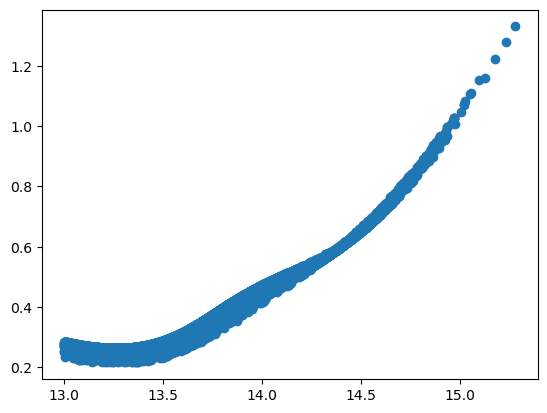

In [47]:
correction_std_ext = np.sqrt( 1 + ( D_ext * B_ext / C_ext  ) - ( B_ext / C_ext ) ** 2 )
lnR_sd_ext_ln1pz_c = lnR_std_ext_ln1pz * correction_std_ext

plt.scatter(np.log10(test_dt["mass"]), lnR_sd_ext_ln1pz_c )


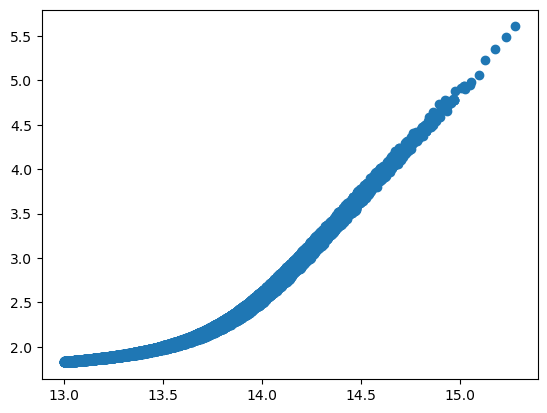

In [49]:
A = lnR_std_ascaso

D = (1.611 - lnR_mean_ascaso) / lnR_std_ascaso 

B = ( 1 / np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ( D ** 2 ) )

C = 1 - 0.5 * ( 1 + erf(D / np.sqrt(2)) )

correction_mean = ( A * B / C )
correction_std = np.sqrt( 1 + ( D * B / C  ) - ( B / C ) ** 2 )

lnR_mean_ascaso_c = lnR_mean_ascaso + correction_mean
lnR_std_ascaso_c = lnR_std_ascaso * correction_std

plt.scatter(np.log10(test_dt["mass"]), lnR_mean_ascaso_c )


### Plot config

In [58]:
def Plot_model(model, data, h_mean, h_std, mean):
    
    fig = plt.figure(figsize=(16,4))
#     gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
    
#     ax1 = fig.add_subplot(gs[0, :], projection='3d')
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    xs = data["redshift"]
    ys = np.log10(data["mass"])
    zs = model

    x2 = h_mean["redshift"]
    y2 = np.log10(h_mean["mass"])
    lnR_mean = np.log(h_mean["richness"])
    std_mean = h_std

    
    #Mu plot config ---------------------------------------
    if mean == True:
        #lnR model, z_mean, y_mean
        
        lb_model = '<$Ln\lambda$| M, z>'
        lb_binned = 'Mean $\ln \lambda_i$'
        m = lnR_mean
        
        if f'{model}' == f'{lnR_mean_ascaso}': 
            #fig.suptitle('Modelo de Ascaso')
            fig.suptitle('$<\ln\lambda| M, z>_{LINEAR}$')
        elif f'{model}' == f'{lnR_mean_ascaso_c}': 
            fig.suptitle('$<\ln\lambda| M, z>_{LINEAR}$')
        elif f'{model}' == f'{lnR_mean_ext_ln1pz}': 
            fig.suptitle('$<\ln\lambda| M, z>_{QUADRATIC}$')
        elif f'{model}' == f'{lnR_mean_ext_ln1pz_c}': 
            fig.suptitle('Modelo Estendido (QUADRATIC)')
        else: 
            pass
    
    #Std plot config ---------------------------------------
    else:
        
        lb_model = '$\sigma_{\ln \lambda}$'
        lb_binned = '$\sigma^{i}$'
        m = std_mean
        
        if f'{model}' == f'{lnR_std_ascaso}': 
            fig.suptitle('Linear Model', size=16)
        elif f'{model}' == f'{lnR_std_ascaso_c}': 
            fig.suptitle('Linear Model', size=16)
        elif f'{model}' == f'{lnR_std_ext_ln1pz}': 
            fig.suptitle('Quadratic Model(ln(1 + z))', size=16)
        elif f'{model}' == f'{lnR_sd_ext_ln1pz_c}': 
            fig.suptitle('Quadratic Model (Corrigido)', size=16)
        else: 
            pass
        
    #-------------------------------------------------------
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('logM')
    fig.colorbar(p1, ax=ax1, label= lb_model)

    ax2.scatter(y2, m, c='k', s=2.0, label=lb_binned)
    p2 = ax2.scatter(ys, zs , c= xs, s=2.0, cmap='cool')
    ax2.set_xlabel('logM')
    ax2.set_ylabel(lb_model)
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(x2, m, c='k', s=2.0, label=lb_binned)
    p3 = ax3.scatter(xs, zs , c=ys, s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel(lb_model)
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()         
    plt.show()



### Mean

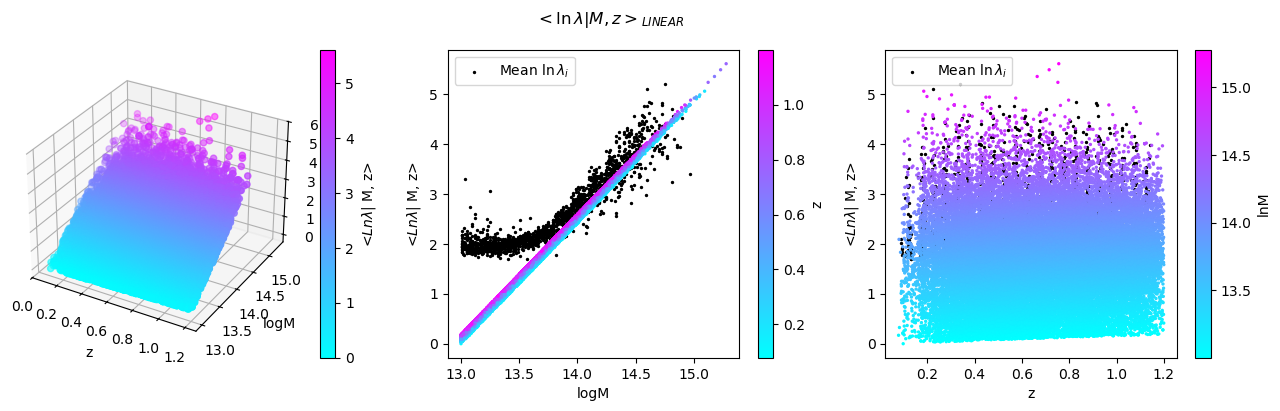

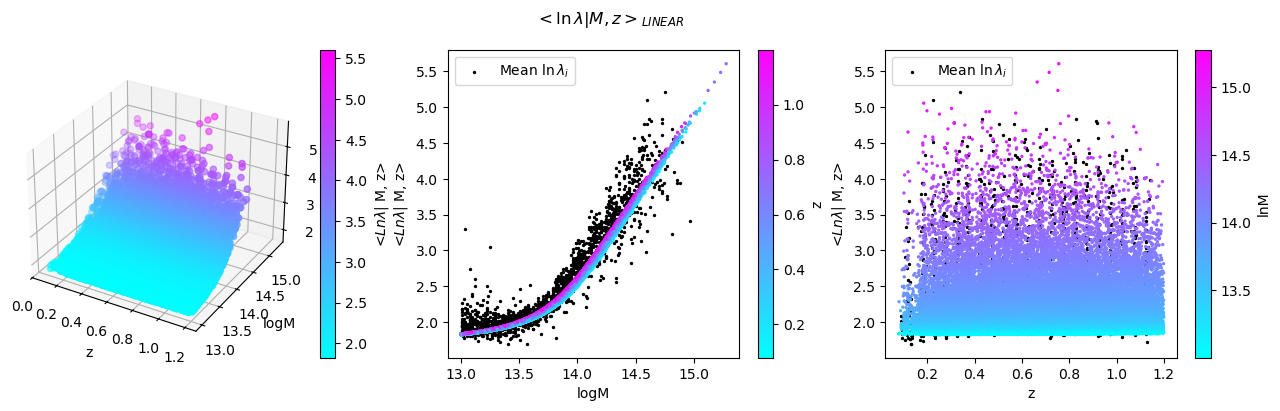

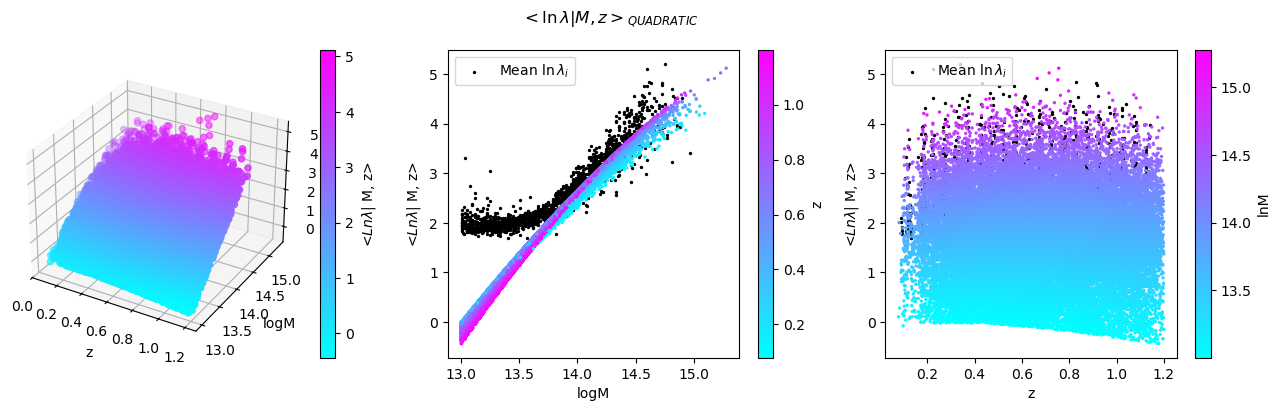

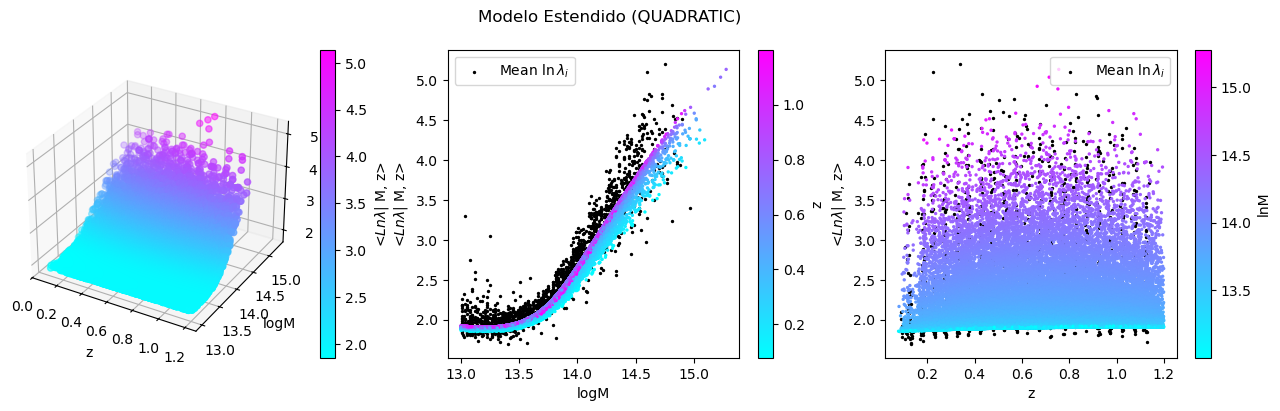

In [59]:
# Plot_model(lnR_mean_ascaso, test_dt, halos_mean, halos_std, mean = True) #Ascaso
Plot_model(lnR_mean_ascaso_c, test_dt, halos_mean, halos_std, mean = True) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, test_dt, halos_mean, halos_std, mean = True) #Extended (ln(1 + z)) 
Plot_model(lnR_mean_ext_ln1pz_c, test_dt, halos_mean, halos_std, mean = True) #Extended (ln(1 + z)) 

# Plot_model(lnR_mean_ext_z, data_test, mean = True)

plt.show()

### Standard deviation

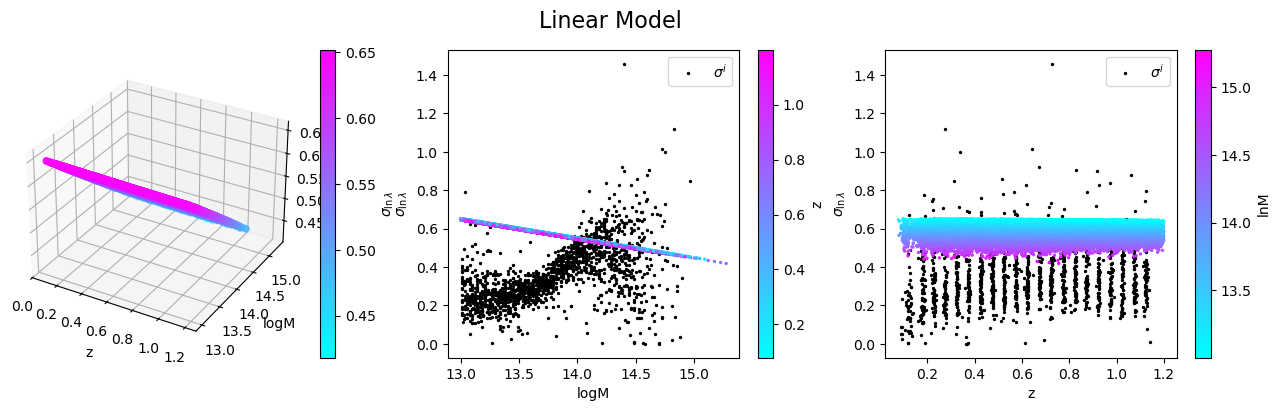

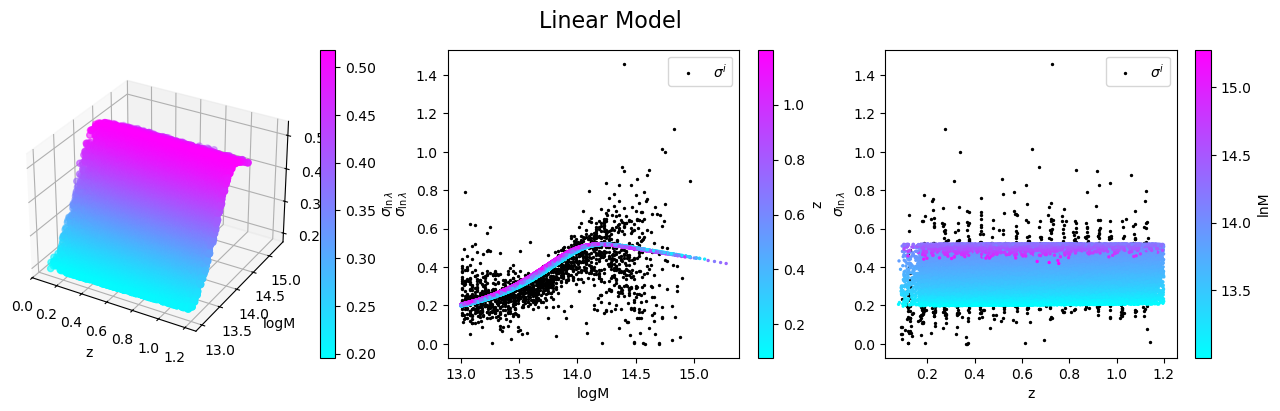

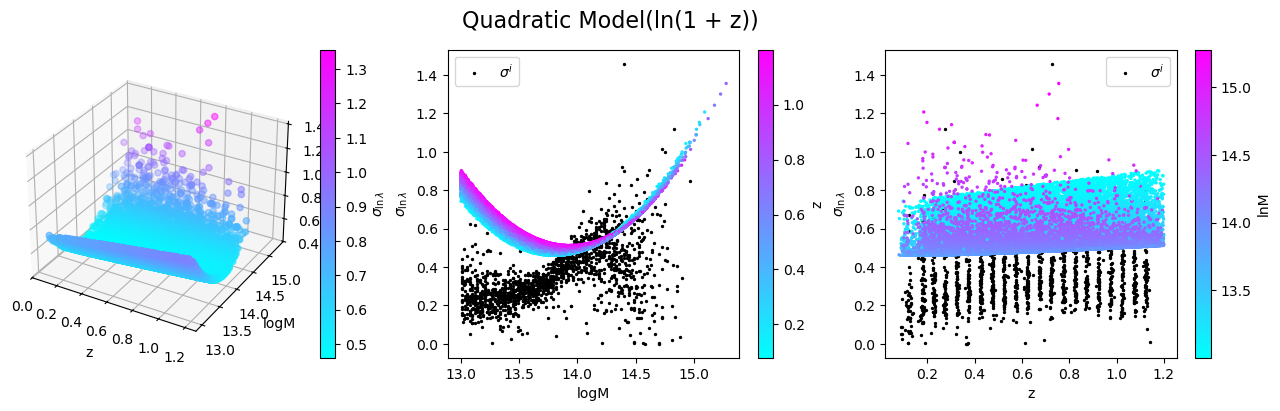

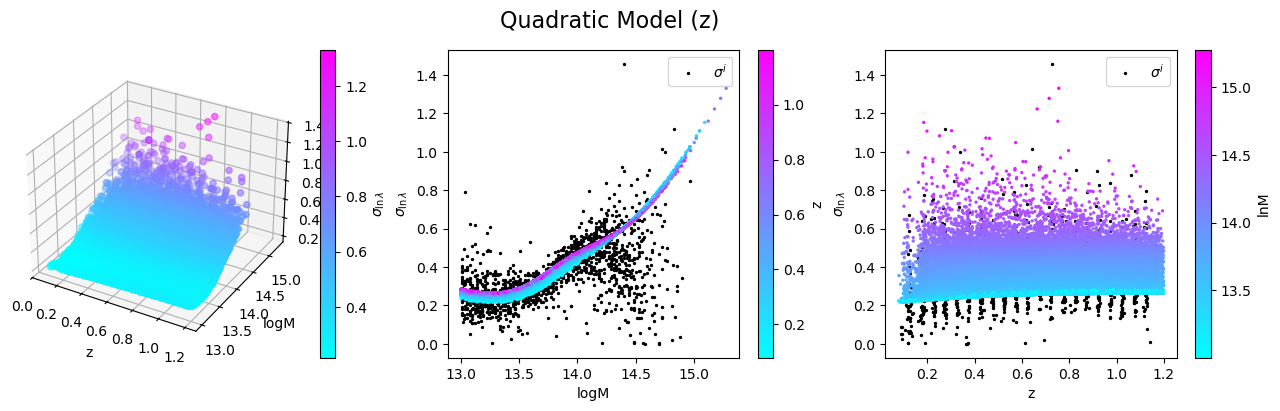

In [57]:
Plot_model(lnR_std_ascaso, test_dt, halos_mean, halos_std, mean=False) #Ascaso
Plot_model(lnR_std_ascaso_c, test_dt, halos_mean, halos_std, mean=False) #Ascaso
Plot_model(lnR_std_ext_ln1pz, test_dt, halos_mean, halos_std, mean=False) #Extended (ln(1 + z)) 
Plot_model(lnR_sd_ext_ln1pz_c, test_dt, halos_mean, halos_std, mean=False) #Extended (ln(1 + z)) 

#Plot_model_std(lnR_std_ext_z, data_train)
plt.show()

